## Load yolov7 data

In [1]:
import os
import numpy as np
import pandas as pd

In [39]:
def convert_segmentation_to_bbox(segmentation):
    points = np.array(segmentation).reshape(-1, 2)
    xmin = np.min(points[:, 0])
    xmax = np.max(points[:, 0])
    ymin = np.min(points[:, 1])
    ymax = np.max(points[:, 1])

    x_center = (xmin + xmax) / 2
    y_center = (ymin + ymax) / 2
    width = xmax - xmin
    height = ymax - ymin

    return x_center, y_center, width, height

In [40]:
def get_filename_no_extension(file_path):
    # Extract the base name of the file (including extension)
    base_name = os.path.basename(file_path)
    # Split the name and extension and return only the name
    file_name_no_extension = os.path.splitext(base_name)[0]
    return file_name_no_extension

In [62]:
def extract_image_number(image_name: str) -> int:
    return int(image_name[image_name.index("(")+1:image_name.index(")")])

In [63]:
def process_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data_rows = []
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        coords = list(map(float, parts[1:]))
        image_name = get_filename_no_extension(file_path)

        if len(coords) > 5:
            # Assume segmentation (more than 5 entries mean pairs of coordinates)
            x_center, y_center, width, height = convert_segmentation_to_bbox(coords)
            
            data_rows.append([class_id, x_center, y_center, width, height, f"{image_name}.jpg", extract_image_number(image_name)])
        else:
            # Already in bbox format
            data_rows.append([class_id] + coords + [f"{get_filename_no_extension(file_path)}.jpg", extract_image_number(image_name)])

    return data_rows

In [66]:
base_path = "../drone-yolov7-dataset/valid"
label_dir = f"{base_path}/labels"
image_dir = f"{base_path}/images"
output_dir = f"{base_path}/converted_labels"
os.makedirs(output_dir, exist_ok=True)

all_data = []

for i, filename in enumerate(os.listdir(label_dir)):
    if filename.startswith('DV') and filename.endswith('.txt'):
        base_name = filename[:-4]  # Remove '.txt' from filename
        image_path = os.path.join(image_dir, f"{base_name}.jpg")

        if os.path.exists(image_path):
            file_path = os.path.join(label_dir, filename)
            data_rows = process_file(file_path)
            all_data.extend(data_rows)
            print(f"Processed {filename} with corresponding image {base_name}.jpg")
        else:
            print(f"Image file {base_name}.jpg not found for {filename}")
# Create DataFrame
df = pd.DataFrame(all_data, columns=['class_id', 'x_center', 'y_center', 'width', 'height', 'image', 'image_number'])

# Save DataFrame to CSV
csv_output_path = os.path.join(output_dir, 'processed_data.csv')
df.to_csv(csv_output_path, index=False)
print(f"Data saved to {csv_output_path}")


Processed DV (749).txt with corresponding image DV (749).jpg
Processed DV (319).txt with corresponding image DV (319).jpg
Processed DV (175).txt with corresponding image DV (175).jpg
Processed DV (525).txt with corresponding image DV (525).jpg
Processed DV (876).txt with corresponding image DV (876).jpg
Processed DV (933).txt with corresponding image DV (933).jpg
Processed DV (899).txt with corresponding image DV (899).jpg
Processed DV (1025).txt with corresponding image DV (1025).jpg
Processed DV (460).txt with corresponding image DV (460).jpg
Processed DV (19).txt with corresponding image DV (19).jpg
Processed DV (821).txt with corresponding image DV (821).jpg
Processed DV (572).txt with corresponding image DV (572).jpg
Processed DV (122).txt with corresponding image DV (122).jpg
Processed DV (437).txt with corresponding image DV (437).jpg
Processed DV (964).txt with corresponding image DV (964).jpg
Processed DV (708).txt with corresponding image DV (708).jpg
Processed DV (358).txt w

## Display some samples

In [65]:
df

,class_id,x_center,y_center,width,height,image,image_number
0,0,0.539062,0.449219,0.075000,0.071094,DV (749).jpg,749
1,0,0.530469,0.485938,0.432812,0.281250,DV (319).jpg,319
2,0,0.517188,0.471094,0.499219,0.124219,DV (175).jpg,175
3,0,0.186719,0.364063,0.228906,0.064062,DV (525).jpg,525
4,0,0.571875,0.416406,0.536719,0.296875,DV (876).jpg,876


In [46]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [67]:
def draw_bounding_boxes(df):
    for _, row in df.iterrows():
        image_path = f'{base_path}/images/' + row['image']  # Adjust the path prefix as necessary
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib

        if image is None:
            print(f"Image not found: {image_path}")
            continue

        # Convert from normalized to absolute coordinates
        x_center = row['x_center'] * image.shape[1]
        y_center = row['y_center'] * image.shape[0]
        width = row['width'] * image.shape[1]
        height = row['height'] * image.shape[0]

        top_left_x = int(x_center - width / 2)
        top_left_y = int(y_center - height / 2)
        bottom_right_x = int(x_center + width / 2)
        bottom_right_y = int(y_center + height / 2)

        # Draw rectangle
        fig, ax = plt.subplots()
        ax.imshow(image)
        rect = plt.Rectangle((top_left_x, top_left_y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.set_title(f"Image: {row['image']}")
        ax.axis('off')  # Turn off axis numbers and ticks
        plt.show()

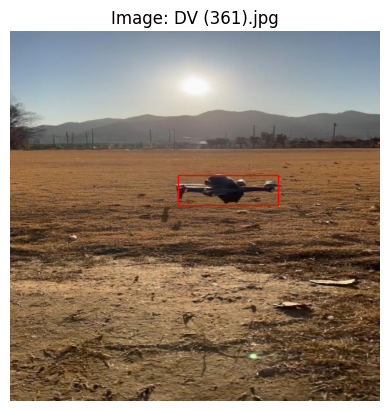

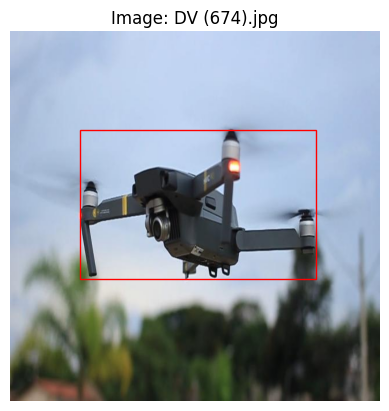

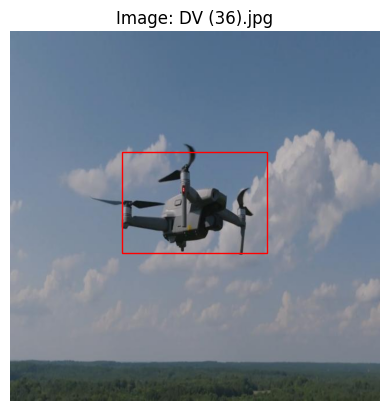

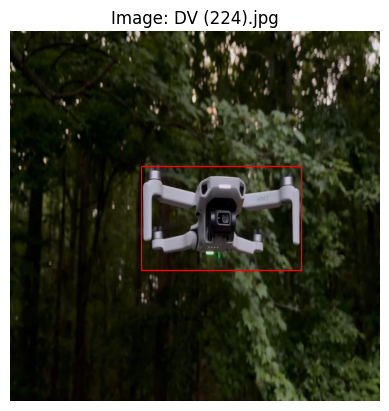

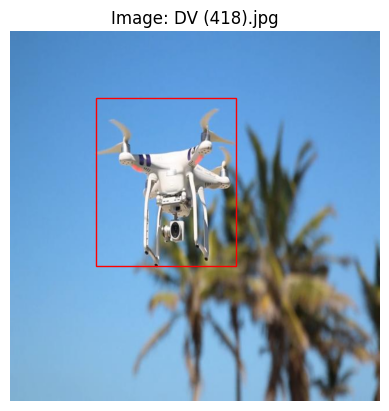

In [69]:
draw_bounding_boxes(df.tail())